1. Fit to ca lines
2. Use ca fit to correct ha lines
3. Fit ha lines

In [77]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle
from scipy.stats import chisquare as chisq

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [45]:
linepath = 'dv_lists/'
os.listdir(linepath)

['ca_dvs.ecsv', 'ha_em_dvs.ecsv', 'ha_ab_dvs.ecsv', '.ipynb_checkpoints']

In [46]:
ca_dvs = Table.read(linepath+'ca_dvs.ecsv')

In [100]:
tc, dvc, dvec = np.array(ca_dvs['MJD']), np.array(ca_dvs['VELOCITY']), np.array(ca_dvs['ERROR'])

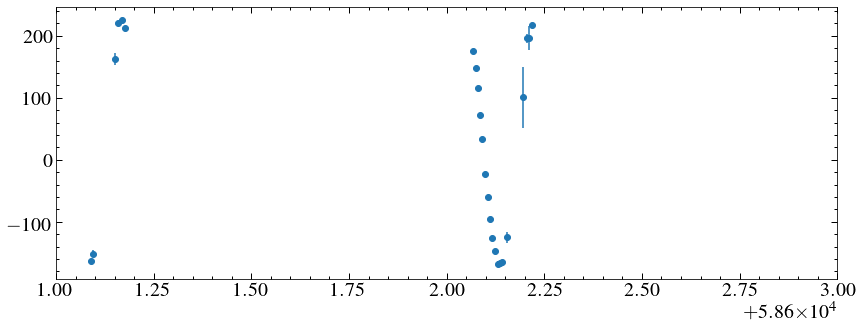

In [51]:
plt.errorbar(tc, dvc, yerr=dvec, ls='none', marker='o')
plt.xlim(58601, 58603)
tcd = tc *24

4.22512929372743


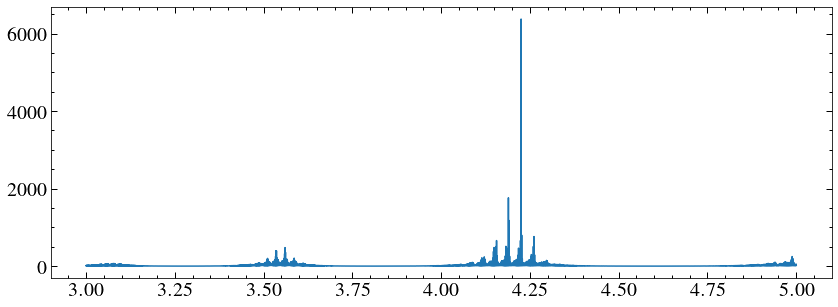

In [60]:
#frequency = np.linspace(1/5, 1/3, 100000)
#power = LombScargle(tc, dvc, normalization='model').power(frequency)
frequency, power = LombScargle(tcd, dvc, dvec, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

<ErrorbarContainer object of 3 artists>

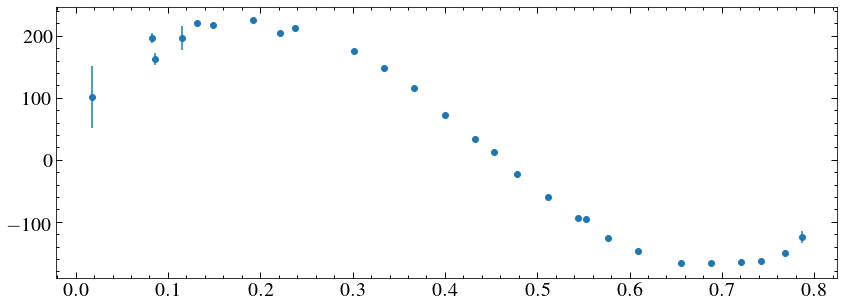

In [61]:
tc_fold = tcd/period %1
plt.errorbar(tc_fold , dvc, yerr=dvec, ls='none', marker='o')

Model: CompoundModel27
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0        amplitude_1     frequency_1       phase_1      
    ------------------ ------------------ ----------- -------------------
    27.049767126215333 197.02635928181655         1.0 0.06205145017743449
[1.19279451 0.64111088 0.00119625]


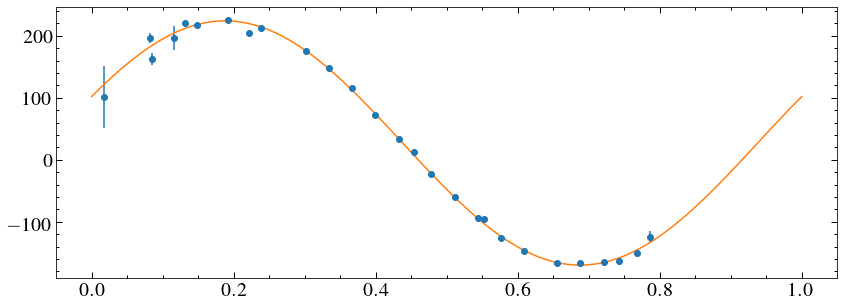

In [118]:
#fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/dvec, maxiter=100000)
print(sine_fit)
plt.errorbar(tc_fold, dvc, yerr=dvec, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

Use reduced chi-squared to improve the uncertainties

3.7923836952485117
3.4798086790185607
3.4037496180071063
3.363576209906153
3.335589620500578
3.312681230001798
3.292334855874834
3.2735456325906296
3.2558673785742958
3.2390791864626465
Model: CompoundModel24
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0       amplitude_1     frequency_1       phase_1      
    ----------------- ------------------ ----------- -------------------
    26.30924389540614 196.57915987158538         1.0 0.06106402187962933
[1.42156936 1.51454875 0.00171295]


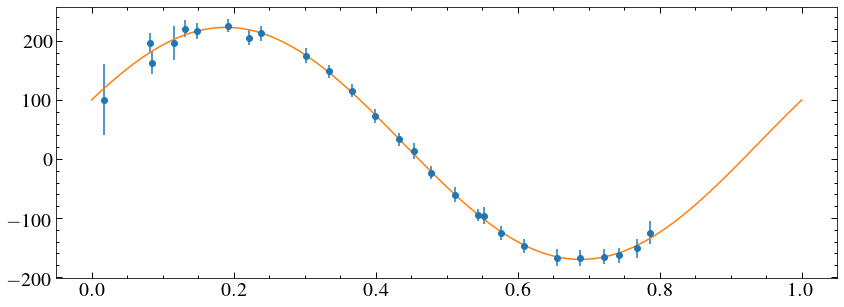

In [111]:
errs = np.array(ca_dvs['ERROR'])

iterate = True
i = 0
while iterate and i < 10:
    i +=1
    sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/errs, maxiter=100000)
    calc_dvs = sine_fit(tc_fold)
    rcs = chisq(dvc, f_exp=calc_dvs, axis = 0)[0]/3
    print (rcs)
    if rcs <= 1.0:
        iterate= False
    else:
        errs += 1.0

print(sine_fit)
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

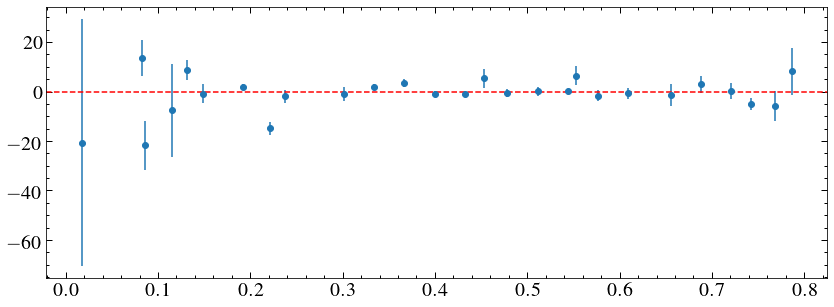

In [116]:
calc_dvs = sine_fit(tc_fold)
plt.errorbar(tc_fold, dvc-calc_dvs, yerr=dvec, marker='o', ls='none')
#plt.errorbar(tc_fold, calc_dvs, marker='o', ls='none')
plt.axhline(ls='--', c='r')

Model: CompoundModel27
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0        amplitude_1     frequency_1       phase_1      
    ------------------ ------------------ ----------- -------------------
    27.049767126215333 197.02635928181655         1.0 0.06205145017743449
[1.19279451 0.64111088 0.00119625]


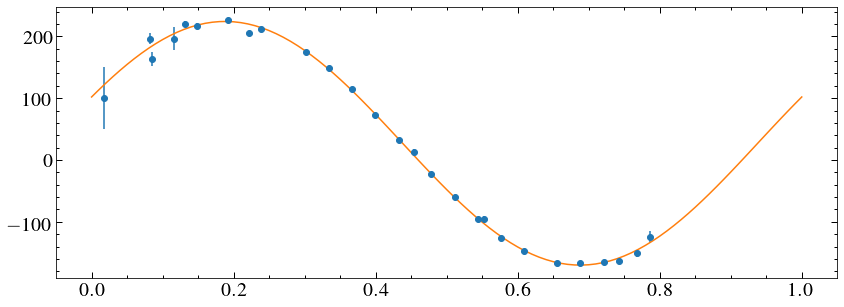

In [229]:
errs = np.array(ca_dvs['ERROR'])

iterate = True
i = 0
while iterate and i < 10:
    i +=1
    sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/errs, maxiter=100000)
    calc_dvs = sine_fit(tc_fold)
    res = abs(dvc-calc_dvs)
    n = 0
    for i in range(len(res)):
        if res[i] > errs[i]:
            errs[i] += 1
            n +=1
    if n == 0: 
        iterate= False

print(sine_fit)
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

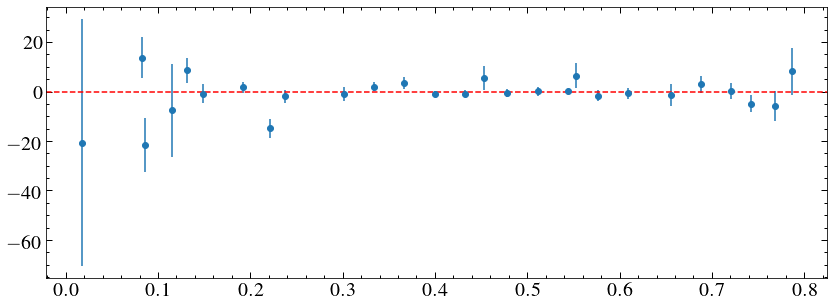

In [122]:
calc_dvs = sine_fit(tc_fold)
plt.errorbar(tc_fold, dvc-calc_dvs, yerr=errs, marker='o', ls='none')
plt.axhline(ls='--', c='r')

Ok, let's try the h alpha lines

In [176]:
hab_dvs = Table.read(linepath+'ha_ab_dvs.ecsv')
ta, dva, dvea = np.array(hab_dvs['MJD']), np.array(hab_dvs['VELOCITY']), np.array(hab_dvs['ERROR'])
hem_dvs = Table.read(linepath+'ha_em_dvs.ecsv')
te, dve, dvee = np.array(hem_dvs['MJD']), np.array(hem_dvs['VELOCITY']), np.array(hem_dvs['ERROR'])

In [177]:
ta[3:] = ta[3:] +150/86400
thd= ta *24
th_fold = thd/period %1
 

<ErrorbarContainer object of 3 artists>

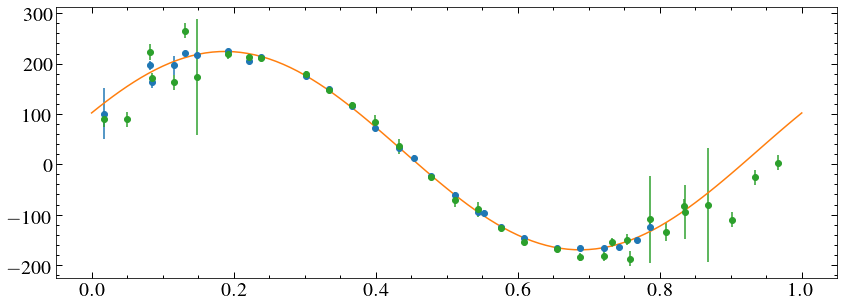

In [178]:
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
plt.plot(phase_t, sine_fit(phase_t))
plt.errorbar(th_fold, dve, yerr=dvee, marker='o', ls='none')


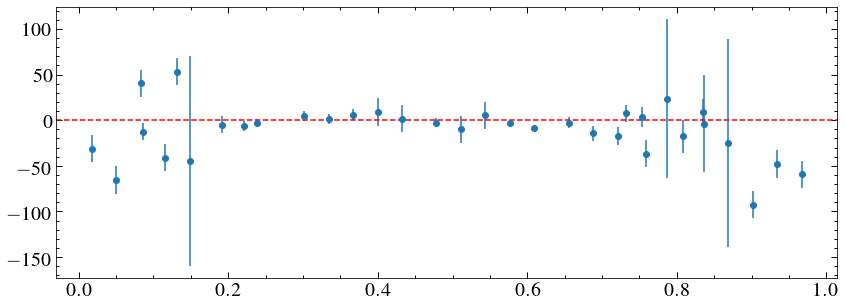

In [179]:
calc_dvs = sine_fit(th_fold)
plt.errorbar(th_fold, dve-calc_dvs, yerr=dvee, marker='o', ls='none')
plt.axhline(ls='--', c='r')

<ErrorbarContainer object of 3 artists>

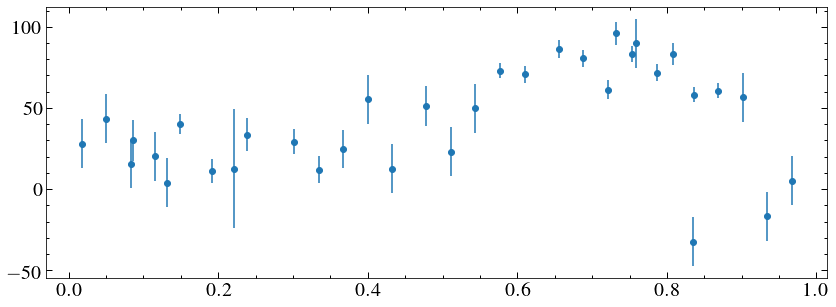

In [180]:
plt.errorbar(th_fold, dva, yerr=dvea, marker='o', ls='none')
#plt.xlim(58602, 58603)

Model: CompoundModel64
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=20.)>

    [1]: <Sine1D(amplitude=10., frequency=1., phase=0.5)>
Parameters:
       amplitude_0       amplitude_1    frequency_1      phase_1      
    ----------------- ----------------- ----------- ------------------
    48.14336683796277 30.08547529909947         1.0 0.5479092622896629
[2.45977418 3.0182167  0.01935997]


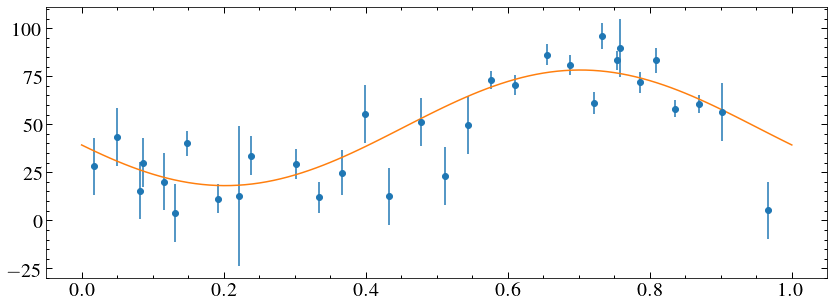

In [217]:
#fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
wt = np.full(len(dvea[dva > 0]), 15)
wt = dvea[dva > 0]
abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 50])) + models.Sine1D(amplitude=10, frequency=1, phase=0.5, bounds=dict(amplitude=[0, 50]), fixed=dict(frequency=1))
abs_fit = fitter(abs_mod, th_fold[dva > 0], dva[dva > 0], weights=1/wt, maxiter=100000)
print(abs_fit)
plt.errorbar(th_fold[dva > 0], dva[dva > 0], yerr=wt, marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

In [175]:
len(tc_fold), len(th_fold)

(27, 25)

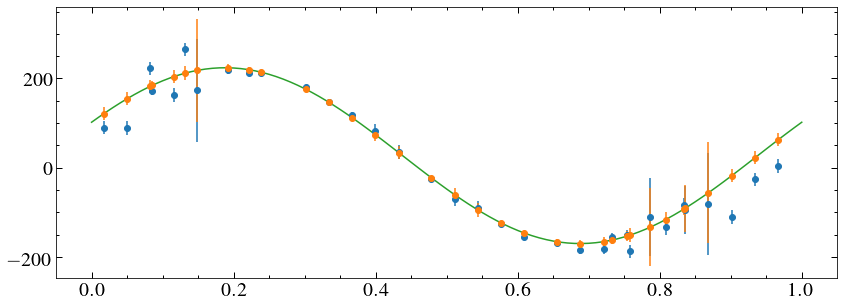

In [184]:
calc_dvs = sine_fit(th_fold)
correction = dve/calc_dvs
plt.errorbar(th_fold, dve, yerr=dvee, marker='o', ls='none')
plt.errorbar(th_fold, dve/correction, yerr=dvee, marker='o', ls='none')
plt.plot(phase_t, sine_fit(phase_t))

<ErrorbarContainer object of 3 artists>

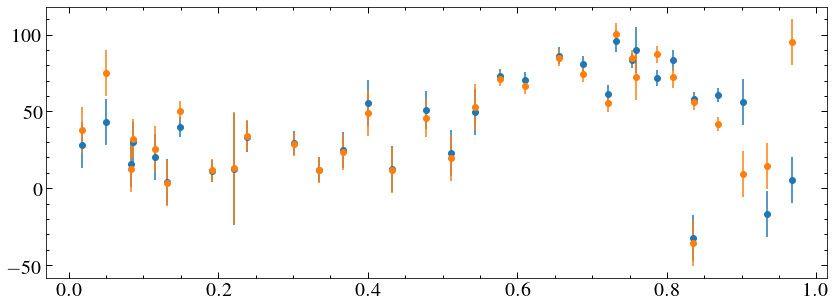

In [186]:
plt.errorbar(th_fold, dva, yerr=dvea, marker='o', ls='none')
plt.errorbar(th_fold, dva/correction, yerr=dvea, marker='o', ls='none')


Model: CompoundModel60
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=20.)>

    [1]: <Sine1D(amplitude=50., frequency=1., phase=0.56205145)>
Parameters:
       amplitude_0       amplitude_1     frequency_1      phase_1      
    ----------------- ------------------ ----------- ------------------
    47.96512177293376 26.844205117477134         1.0 0.5503792336674225
[3.46780322 4.26982366 0.03035328]


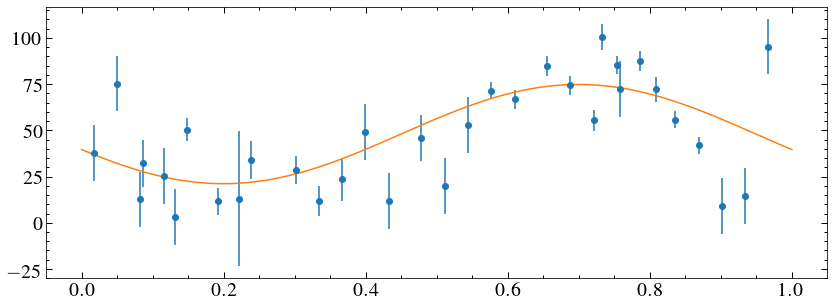

In [209]:
cor_dv = dva/correction
#fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 50])) + models.Sine1D(amplitude=50, frequency=1, phase=sine_fit.phase_1 +0.5, bounds=dict(amplitude=[0, 100]), fixed=dict(frequency=1))
abs_fit = fitter(abs_mod, th_fold[cor_dv >0], cor_dv[cor_dv >0], weights=1/dvea[cor_dv >0], maxiter=100000)
print(abs_fit)
plt.errorbar(th_fold[cor_dv >0], cor_dv[cor_dv >0], yerr=dvea[cor_dv >0], marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print (fit_e)

Taking those values as read, what is the companion mass?

In [213]:
v1_v2 = 197.02635928181655/30.322668317365522
m_wd = 0.49 
m_com = m_wd /v1_v2
print(m_com)

0.07541177500141906


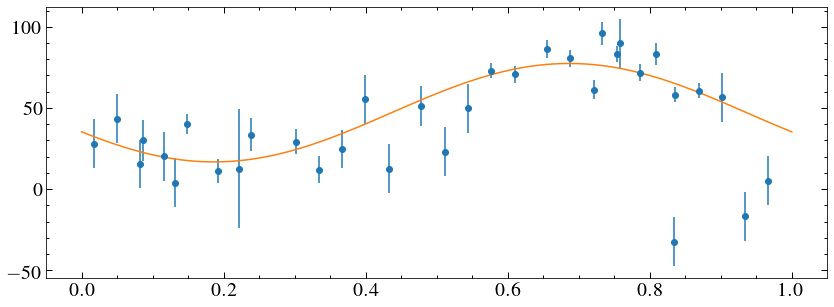

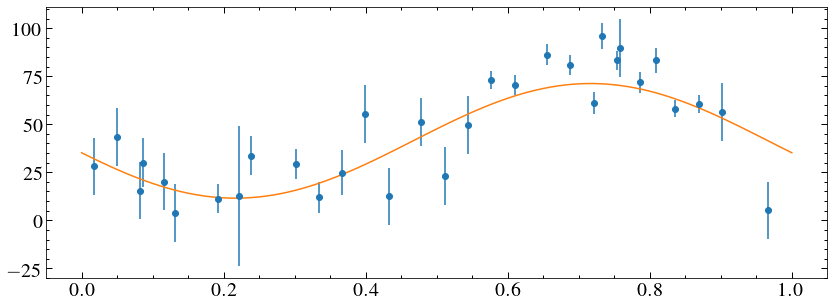

Model: CompoundModel73
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=20.)>

    [1]: <Sine1D(amplitude=10., frequency=1., phase=0.5)>
Parameters:
       amplitude_0        amplitude_1    frequency_1      phase_1      
    ------------------ ----------------- ----------- ------------------
    46.062949783079745 33.94088649979035         1.0 0.5510819224687453
[1.59362062 2.01047864 0.01015373]


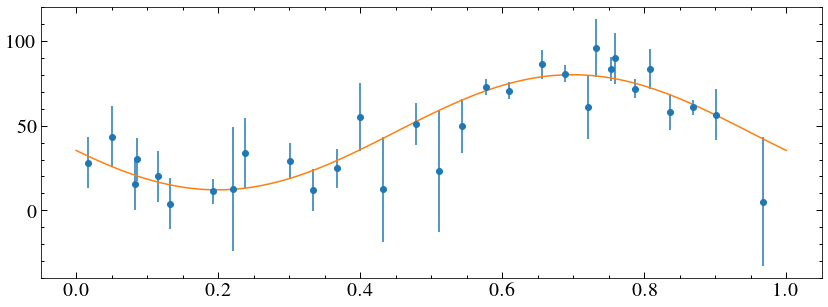

In [232]:
fitter = fitting.LevMarLSQFitter()

abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 50])) + models.Sine1D(amplitude=10, frequency=1, phase=0.5, bounds=dict(amplitude=[0, 50]), fixed=dict(frequency=1))
abs_fit = fitter(abs_mod, th_fold, dva, weights=1/dvea, maxiter=100000)
#print(abs_fit)
plt.errorbar(th_fold, dva, yerr=dvea, marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#print(fit_e)
plt.show()

calc = abs_fit(th_fold)
res = abs(dva - calc)
mask = (res < 3*dvea)
t_in, dv_in, e_in = th_fold[mask], dva[mask], dvea[mask]
abs_fit = fitter(abs_mod, t_in, dv_in, weights=e_in, maxiter=100000)
plt.errorbar(t_in, dv_in, yerr=e_in, marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
plt.show()

iterate = True
i = 0
while iterate and i < 100:
    i +=1
    abs_fit = fitter(abs_mod, t_in, dv_in, weights=1/e_in, maxiter=100000)
    calc = abs_fit(t_in)
    res = abs(dv_in - calc)
    n = 0
    for i in range(len(res)):
        if res[i] > e_in[i]:
            e_in[i] += 1
            n +=1
    if n == 0: 
        iterate= False
        
plt.errorbar(t_in, dv_in, yerr=e_in, marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
print(abs_fit)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)    

So ...

In [233]:
v1_v2 = 197.02635928181655/33.94088649979035
m_wd = 0.49 
m_com = m_wd /v1_v2
print(m_com)

0.08441019996268154


M8?

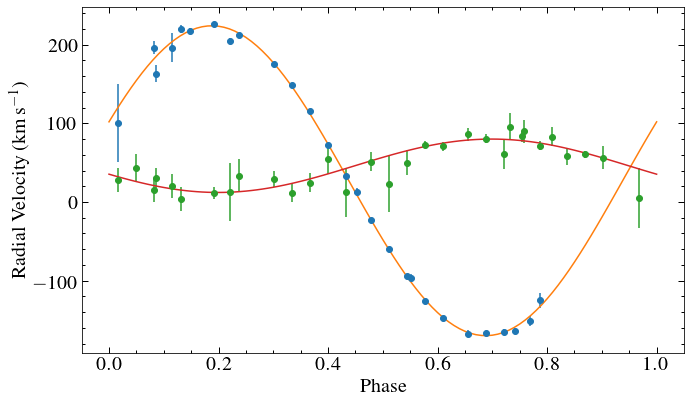

In [256]:
plt.figure(figsize=(10,6))
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
plt.errorbar(t_in, dv_in, yerr=e_in, marker='o', ls='none')
plt.plot(phase_t, abs_fit(phase_t))
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.tight_layout()
plt.savefig('binary_rvs.png', dip=150)

In [319]:
ep = 0.2/period
m1 = 0.49 #Msun, from G+2015
m1e = 0.03
v1 = 34
v1e = v1*((2.0/v1)**2+ep**2)**0.5
v2 = 197.0
v2e = v2*((0.6/v2)**2+ep**2)**0.5
v1v2 = v1/v2
v1v2e = ((v1e/v1)**2+(v2e/v2)**2)**0.5
print(v1v2, v1v2e)
m2 = m1 * v1v2
m2e = m2 * (v1v2e**2+(m1e/m1)**2)**0.5
print (m2)
print(m2e)

0.17258883248730963 0.08914582225855307
0.08456852791878172
0.009145692679434306


Need to add: errors on period, white dwarf mass- Done.  What does the system look like?  

So: M2 = 0.08 pm 0.01 Msun. Error seems too small? Bigger than Longstaff result, as I would expect.

In [246]:
import astropy.constants as const

In [255]:
a = ((((const.G*(m1+m2)*u.Msun)/(4*np.pi)**2)*(period*u.hour)**2)**(1/3)).to(u.Rsun)
a

<Quantity 0.69228392 solRad>

Errors on period? Two ways- random data, missing data.

4.226953752501198


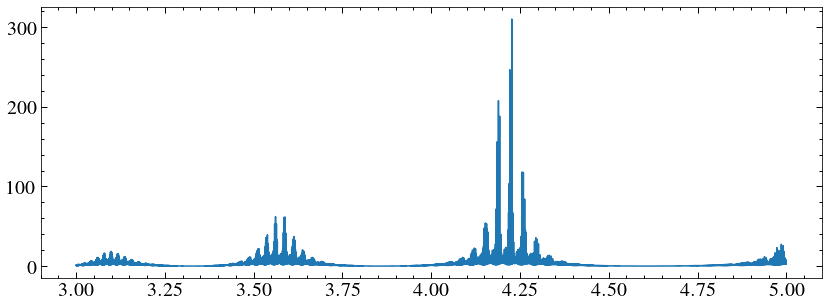

In [297]:
frequency = np.linspace(1/5, 1/3, 10000)
power = LombScargle(tcd, dvc, normalization='model').power(frequency)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

In [298]:
#bootstrap
#plt.errorbar(tc, dvc, yerr=dvec, ls='none', marker='o')
fake_periods = []
i = 0
while i < 1000:
    fake_dv = np.random.normal(dvc, dvec)
    power = LombScargle(tcd, fake_dv, normalization='model').power(frequency)
    fake_period = 1/frequency[np.argmax(power)]
    fake_periods.append(fake_period)
    i +=1
fake_periods = np.array(fake_periods)
print(np.mean(fake_periods), np.median(fake_periods), np.std(fake_periods))


4.177509016722745 4.226953752501198 0.16040878978223683


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        156.,   0.,  46.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  85.,   0.,   0., 639.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([4.1  , 4.102, 4.104, 4.106, 4.108, 4.11 , 4.112, 4.114, 4.116,
        4.118, 4.12 , 4.122, 4.124, 4.126, 4.128, 4.13 , 4.132, 4.134,
        4.136, 4.138, 4.14 , 4.142, 4.144, 4.146, 4.148, 4.15 , 4.152,
        4.154, 4.156, 4.158, 4.16 , 4.162, 4.164, 4.166, 4.168, 4.17 ,
        4.172, 4.174, 4.176, 4.178

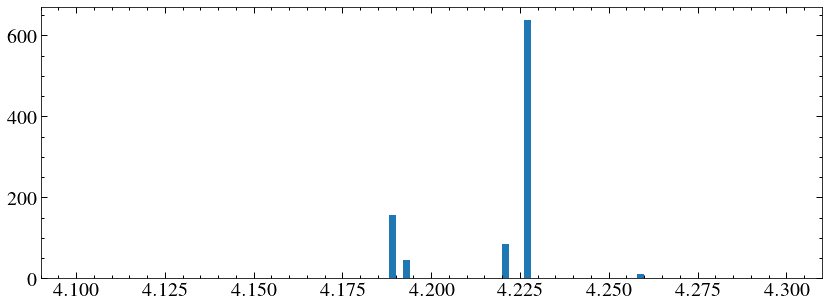

In [299]:
plt.hist(fake_periods, range=[4.1, 4.3], bins=100)

In [310]:
#missing data
#10%
all_args = np.arange(len(tcd), dtype=int)

cuts = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
means = []
meds = []
stds = []
for c in cuts:
    fake_periods2 = []
    i = 0
    while i < 1000:
    
        random_args = np.random.choice(all_args, size=int(c*len(tcd)), replace=False)
        power = LombScargle(tcd[random_args], dvc[random_args], normalization='model').power(frequency)
        fake_period = 1/frequency[np.argmax(power)]
        fake_periods2.append(fake_period)
        i +=1
    fake_periods2 = np.array(fake_periods2)
    print(c, np.mean(fake_periods2), np.median(fake_periods2), np.std(fake_periods2))
    means.append(np.mean(fake_periods2))
    meds.append(np.median(fake_periods2))
    stds.append(np.std(fake_periods2))
        
    



0.9 4.218545389114872 4.226953752501198 0.037754969285915714
0.8 4.208556918156877 4.217919514047076 0.0782229496841757
0.7 4.199335271436636 4.217919514047076 0.11108019916829427
0.6 4.1681767738618 4.217919514047076 0.1907720856007655
0.5 4.105240314791764 4.21341686097143 0.2871898200756396
0.4 4.030342149230205 4.21341686097143 0.39502125092984525
0.3 3.983045637587293 4.203262057562425 0.44189038378217915
0.2 4.073485948370552 4.206326961658734 0.46309919677935313


/home/david/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/home/david/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:127: RuntimeWarning: invalid value encountered in true_divide
  power /= YY - power
/home/david/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:127: RuntimeWarning: divide by zero encountered in true_divide
  power /= YY - power
/home/david/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


0.1 4.944195347337609 4.999666655555185 0.29607819917953176


Both estimates seem to give ~0.2, let's add that in as a % error 

<ErrorbarContainer object of 3 artists>

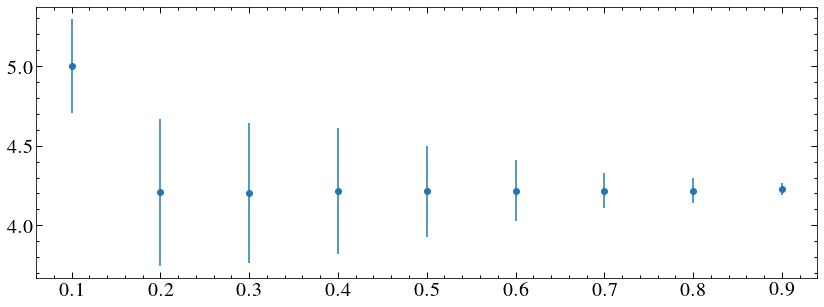

In [316]:
plt.errorbar(cuts, meds, yerr=stds, marker='o', ls='none')
#plt.errorbar(cuts, means, yerr=stds, marker='o', ls='none')

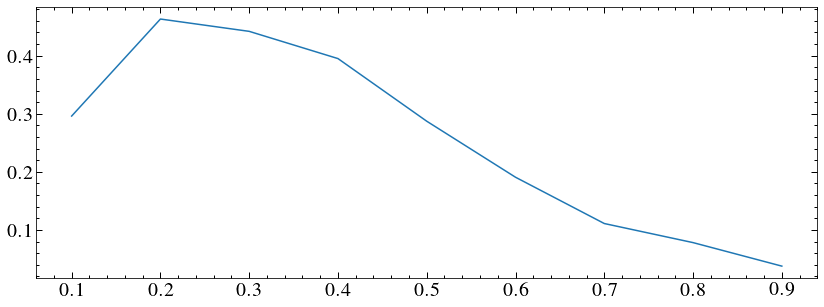

In [317]:
plt.plot(cuts, stds)

In [343]:
"""fitter = fitting.LevMarLSQFitter()
#fitter = fitting.SLSQPLSQFitter()
p_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1/4.12, bounds=dict(amplitude=[100, 200], frequency=[1/4,1/4.5]))
p_fit = fitter(p_mod, tcd[7:], dvc[7:], weights=1/dvec[7:], maxiter=1000000)
print(p_fit)
p = 1/p_fit.frequency_1
print(p)
plt.errorbar((tcd/p %1), dvc, yerr=dvec, marker='o', ls='none')
#phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, p_fit(phase_t))
#fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#print(fit_e)"""

"fitter = fitting.LevMarLSQFitter()\n#fitter = fitting.SLSQPLSQFitter()\np_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1/4.12, bounds=dict(amplitude=[100, 200], frequency=[1/4,1/4.5]))\np_fit = fitter(p_mod, tcd[7:], dvc[7:], weights=1/dvec[7:], maxiter=1000000)\nprint(p_fit)\np = 1/p_fit.frequency_1\nprint(p)\nplt.errorbar((tcd/p %1), dvc, yerr=dvec, marker='o', ls='none')\n#phase_t = np.arange(0,1.01, 0.01 )\nplt.plot(phase_t, p_fit(phase_t))\n#fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\n#print(fit_e)"

Better mass estimates - need better WD fit, Odette?

In [345]:
par = 3.6514972309380083
d = 1/par*1e3
print(d)

273.8602651885667


G+ estimate is 284, not bad

In [346]:
period

4.226953752501198